C:\Users\Aryan Gupta\AppData\Local\Temp\ipykernel_2980\205678530.py:30: UserWarning: NOLA condition failed, STFT may not be invertible. Possibly due to missing boundary
  _, y_rec = istft(sub_mag * np.exp(1j * phase), fs=sr,


Denoised file written to: C:/Users/Aryan Gupta/OneDrive/Desktop/projects/sound_ML/Demo/p226_001.wav


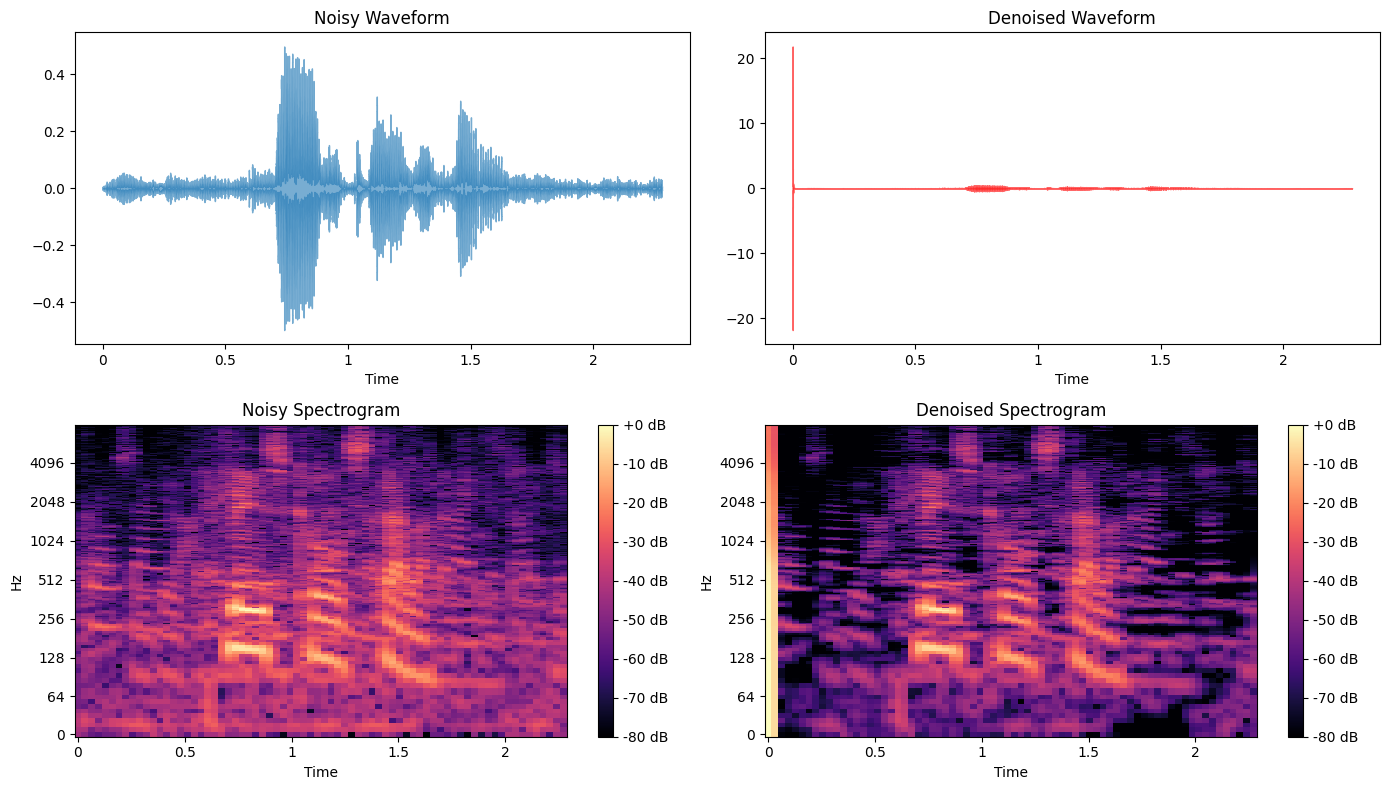

In [10]:
import os
import numpy as np
# (Workaround for librosa on numpy ≥1.24)
np.complex = complex

import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import stft, istft

# ——— CONFIGURATION ———
noisy_file = r"C:/Users/Aryan Gupta/OneDrive/Desktop/projects/sound_ML/p226_001.wav"
out_file   = r"C:/Users/Aryan Gupta/OneDrive/Desktop/projects/sound_ML/Demo/p226_001.wav"
frame_len, hop_len = 2048, 512

# ——— HELPERS ———
def extract_noise_profile(y, sr, duration=0.5):
    n = int(sr * duration)
    noise = y[:n]
    _, _, Zxx = stft(noise, fs=sr, nperseg=frame_len,
                     noverlap=frame_len-hop_len, boundary=None)
    return np.mean(np.abs(Zxx), axis=1)

def spectral_subtract(y, sr, noise_spec):
    _, _, Zxx = stft(y, fs=sr, nperseg=frame_len,
                     noverlap=frame_len-hop_len, boundary=None)
    mag, phase = np.abs(Zxx), np.angle(Zxx)
    sub_mag = np.maximum(mag - noise_spec[:, None], 0.0)
    _, y_rec = istft(sub_mag * np.exp(1j * phase), fs=sr,
                     nperseg=frame_len, noverlap=frame_len-hop_len,
                     boundary=None)
    # Force same length as input
    y_rec = librosa.util.fix_length(y_rec, size=len(y))
    return y_rec

# ——— LOAD NOISY AUDIO ———
if not os.path.exists(noisy_file):
    raise FileNotFoundError(f"Noisy file not found: {noisy_file}")
y_noisy, sr = librosa.load(noisy_file, sr=None)

# ——— DENOISE ———
noise_spec  = extract_noise_profile(y_noisy, sr, duration=0.5)
y_denoised  = spectral_subtract(y_noisy, sr, noise_spec)

# ——— SAVE OUTPUT ———
os.makedirs(os.path.dirname(out_file), exist_ok=True)
sf.write(out_file, y_denoised, sr)
print(f"Denoised file written to: {out_file}")

# ——— VISUALIZATION ———
plt.figure(figsize=(14, 8))

# 1. Waveforms
plt.subplot(2, 2, 1)
librosa.display.waveshow(y_noisy, sr=sr, alpha=0.6)
plt.title('Noisy Waveform')

plt.subplot(2, 2, 2)
librosa.display.waveshow(y_denoised, sr=sr, color='r', alpha=0.6)
plt.title('Denoised Waveform')

# 2. Spectrograms (log scale)
D_noisy    = librosa.amplitude_to_db(
    np.abs(librosa.stft(y_noisy,    n_fft=frame_len, hop_length=hop_len)),
    ref=np.max
)
D_denoised = librosa.amplitude_to_db(
    np.abs(librosa.stft(y_denoised, n_fft=frame_len, hop_length=hop_len)),
    ref=np.max
)

plt.subplot(2, 2, 3)
librosa.display.specshow(D_noisy,    sr=sr, hop_length=hop_len, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Noisy Spectrogram')

plt.subplot(2, 2, 4)
librosa.display.specshow(D_denoised, sr=sr, hop_length=hop_len, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Denoised Spectrogram')

plt.tight_layout()
plt.show()
